### Understand disparities in the distribution of deceptive ads (scam+clickbait+prohibited)

Remember to peek at `finegrained/global-vs-contextual-harms-frequency.ipynb` for reference, it includes the most polished non-paper-story versions of the analyses.

**RQ2: Is there bias in which participants receive which ads?**
We need to be able to:
- comment on the overall skew of deceptive ads in our dataset, compared to benign or other kinds
- comment on the demographics of the people who see the most deceptive ads in our dataset

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
from collections import defaultdict

# takes dict from adid -> codes and returns dict of code counts, returns proportions of total if norm=True
def count_code_props(codes, freqs=None, norm=True):
    # `codes`: {adid: codes_string}, `freqs`: number of times each ad was seen, `norm`: counts or proportions
    counts = defaultdict(lambda: 0)
    for aid in codes:
        for code in codes[aid].split(';'):
            if "Can't determine" not in code and code != 'Study':
                # do not count auxiliary codes
                if freqs is not None:
                    # freqs should be index-set dataframe of the participant's ad counts
                    counts[code] += int(freqs.loc[str(aid)])
                else:
                    counts[code] += 1
                
    if norm:
        return {c: counts[c]/sum(counts.values()) for c in counts}
    else:
        return counts

### CDF of Ad Types

In [3]:
codes_file = '../../db-processing/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')

freqs_file = '../../db-processing/participant_ad_freqs.tsv'
freqs = pd.read_csv(freqs_file, sep='\t', dtype={'pid': 'str', 'adid': 'str', 'frequency': 'Int32'})
freqs = freqs.set_index(['pid', 'adid'])
# freqs can be accessed via: int(adcounts.loc['100060217151474', '23847280837380437'])

# load the pid adid mapping for each annotation task
# limiting this analysis to ads/participants that we have labeled data for
pid_adid_files = [f'../../db-processing/surveys/survey-{n}/survey{n}_coding_subsample.tsv'
                 for n in range(1, 8)]
# survey #1 is an outlier, it had two files
pid_adid_files.append('../../db-processing/surveys/survey-1/survey1_batch2_coding_subsample.tsv')

# load up all files
pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')],
                         ignore_index=True)
pids = set(pid_adid['pid'])

coded_ads = pid_adid.merge(codes, how='inner', left_on='adid', right_on='adid')
part_ad_counts = {p: 0 for p in pids}
for row in coded_ads.itertuples():
    pid, adid = row.pid, str(row.adid)    
    if str(pid) not in freqs.index:
        print(f'Skipiping {pid}')
        continue
    part_ad_counts[pid] += int(freqs.loc[str(pid), str(adid)])
# remove zeros -- there seem to be 3 such participants
part_ad_counts = {p: part_ad_counts[p] for p in part_ad_counts if part_ad_counts[p] > 0}
# revise list of pids
pids = list(part_ad_counts.keys())

Skipiping 445018
Skipiping 445018
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 403842
Skipiping 445018
Skipiping 445018


In [18]:
len([p for p in pids if part_ad_counts[p] >= 30])

149

In [4]:
part_code_counts = {}

for pid in pids:
    # narrow down to only this participant's ads
    joiner = pid_adid[pid_adid['pid'] == str(pid)]
    # fetch codes for these ads
    joined = joiner.merge(codes, how='inner', left_on='adid', right_on='adid')
    # count frequencies for codes for participant
    if str(pid) not in freqs.index:
        print(f'{pid} not in freqs DF')
        continue
    code_counts = count_code_props(dict(joined[['adid', 'codes']].values), freqs.loc[str(pid)], norm=False)
    part_code_counts[str(pid)] = code_counts

Benign 0.447
Deceptive 0.313
Other 0.38


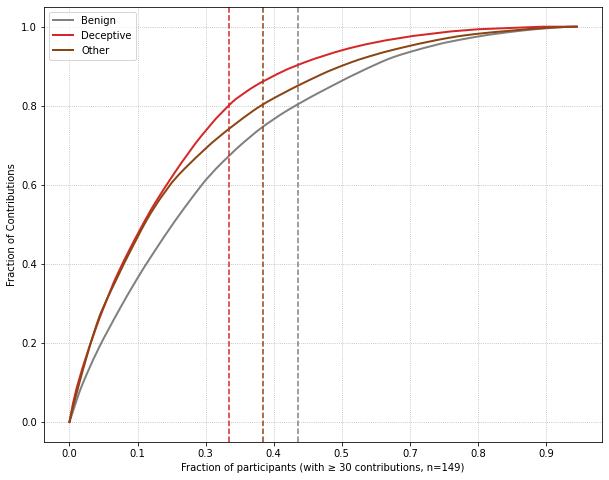

In [19]:
# harmful, prohibited, and clickbait separately
groups = {
    'Benign': ['Benign'],
    'Deceptive': ['Potentially Harmful', 'Potentially Prohibited', 'Clickbait'],
    'Other': ['Financial', 'Opportunity', 'Healthcare', 'Political', 'Sensitive', 'CA Lawsuit']
}
colors = {'Benign': 'grey', 'Other': 'saddlebrown', 'Deceptive': 'tab:red'}
f, ax = plt.subplots(figsize=(10, 8))
# not really outliers, but save the highest consumers of 
outlier_pids = {'Benign': None, 'Deceptive': None, 'Other': None}

# TODO: make sure this is accurate
analysis_parts = [str(p) for p in part_ad_counts if part_ad_counts[p] >= 30]
# analysis_parts = [str(p) for p in pids]
for g in ['Benign', 'Deceptive', 'Other']:
    group_counts = np.zeros(len(analysis_parts))
    for c in groups[g]:
        group_counts += [part_code_counts[pid].get(c, 0) for pid in analysis_parts]
            
    pdf = np.array(group_counts) / sum(group_counts)   
    # (PDF, PID) list of tuples in descending order
    pid_pdf = sorted(zip(pdf, analysis_parts), key=lambda tup: tup[0], reverse=True)
    pdf_desc = [t[0] for t in pid_pdf]
    pid_order = [t[1] for t in pid_pdf]
    
    cdf = np.cumsum(pdf_desc)
    cdf = np.array([0, *cdf])
    plt.plot(np.arange(len(cdf)), cdf, label=g,
         color=colors[g], lw=2)
    
    # Mark 80% point on the CDF
    cdf_80 = np.argmax([cdf >= .8])
    print(g, round(cdf_80/len(cdf), 3))
    plt.axvline(cdf_80, color=colors[g], ls='--')    
    
    # save PIDs for consumers beyond the 80th percentile
    outlier_pids[g] = pid_order[:cdf_80]
    
plt.legend()
plt.ylabel('Fraction of Contributions')
plt.xticks(np.arange(len(cdf))[::20], [round(x, 1) for x in np.arange(0, 1.02, 1/len(cdf))[::20]])
plt.xlabel(f'Fraction of participants (with ≥ 30 contributions, n={len(pdf)})')
plt.grid(ls=':')

# plt.savefig('../figures/CDF_benign_vs_deceptive.pdf', bbox_inches='tight', dpi=150)

### Demographics Table of Top Consumers

In [208]:
gender_file = '../../db-processing/participant-demographics/participant_genders_all.csv'
gender = pd.read_csv(gender_file)
gender = dict(gender.values)

ages_file = '../../db-processing/participant-demographics/participant_ages_all.csv'
ages = pd.read_csv(ages_file)
ages = dict(ages.values)        

fbuse_file = "../../db-processing/participant-demographics/participant_fbuse.csv"
fbuse = pd.read_csv(fbuse_file)
fbuse = dict(fbuse.values)

# for making codes readable
numeric_codes = {
    'gender': {1: 'F', 2: 'M', 3: 'NB', 4: 'Other'},
    'fbuse': {1: '<10m', 2: '10-30m', 3: '30-60m', 4: '1-2h', 5: '2-3h', 6: '3h+'}
}

In [212]:
# for gender: 

def show_demographics(given_pids):
    global gender, ages, fbuse
    print('given_pids:', len(given_pids), '\n')
    
    dems_file = '../../db-processing/participant_dems.tsv'
    dems = pd.read_csv(dems_file, sep='\t')    
    
    # limit demographics to the list of given PIDs    
    dems = dems[dems['pid'].isin(given_pids)]
    dems['gender'] = pd.Series(dtype='int')
    dems['fbuse'] = pd.Series(dtype='int')
    for i in dems.index:
        pid = dems.loc[i]['pid']
        # fill up additional columns taken from other files
        if pid in gender:
            dems.loc[i, 'gender'] = int(gender[pid])
        if pid in fbuse:
            dems.loc[i, 'fbuse'] = int(fbuse[pid])
    
    table = []
    for var in ['gender', 'income', 'age', 'fbuse', 'education']:
        table.append(['-----', var.upper(), '-----'])
        table.append(['-----', '-----', '-----'])
        vals = dict(dems[var].value_counts())
        for v in vals:
            if var in numeric_codes:
                # row format: variable_value, count, percentage (make value interpretable)
                table.append([numeric_codes[var][int(v)],
                              vals[v], f'{round(vals[v]/sum(vals.values()) * 100, 2)}%'])
            else:
                # variable_value, count, percentage
                table.append([v, vals[v], f'{round(vals[v]/sum(vals.values()) * 100, 2)}%'])
        
    print(tabulate(table))

In [213]:
show_demographics(analysis_parts)

given_pids: 135 

-------------  ---------  ------
-----          GENDER     -----
-----          -----      -----
F              62         51.67%
M              56         46.67%
NB             2          1.67%
-----          INCOME     -----
-----          -----      -----
25k-50k        32         26.45%
100k+          30         24.79%
under-25k      19         15.7%
75k-100k       18         14.88%
50k-75k        18         14.88%
no-answer      4          3.31%
-----          AGE        -----
-----          -----      -----
25-34          42         34.71%
35-44          29         23.97%
45-54          17         14.05%
18-24          16         13.22%
55-64          13         10.74%
65+            4          3.31%
-----          FBUSE      -----
-----          -----      -----
30-60m         33         27.5%
1-2h           27         22.5%
3h+            27         22.5%
10-30m         21         17.5%
2-3h           12         10.0%
-----          EDUCATION  -----
-----     

In [215]:
show_demographics(outlier_pids['Deceptive'])

given_pids: 47 

------------  ---------  ------
-----         GENDER     -----
-----         -----      -----
M             25         60.98%
F             16         39.02%
-----         INCOME     -----
-----         -----      -----
100k+         13         31.71%
under-25k     8          19.51%
25k-50k       8          19.51%
50k-75k       6          14.63%
75k-100k      3          7.32%
no-answer     3          7.32%
-----         AGE        -----
-----         -----      -----
25-34         12         29.27%
35-44         11         26.83%
55-64         9          21.95%
45-54         4          9.76%
65+           3          7.32%
18-24         2          4.88%
-----         FBUSE      -----
-----         -----      -----
3h+           13         31.71%
30-60m        12         29.27%
10-30m        8          19.51%
1-2h          6          14.63%
2-3h          2          4.88%
-----         EDUCATION  -----
-----         -----      -----
college       17         41.46%
gradsch